In [1]:
!pip install numpy open3d matplotlib pillow

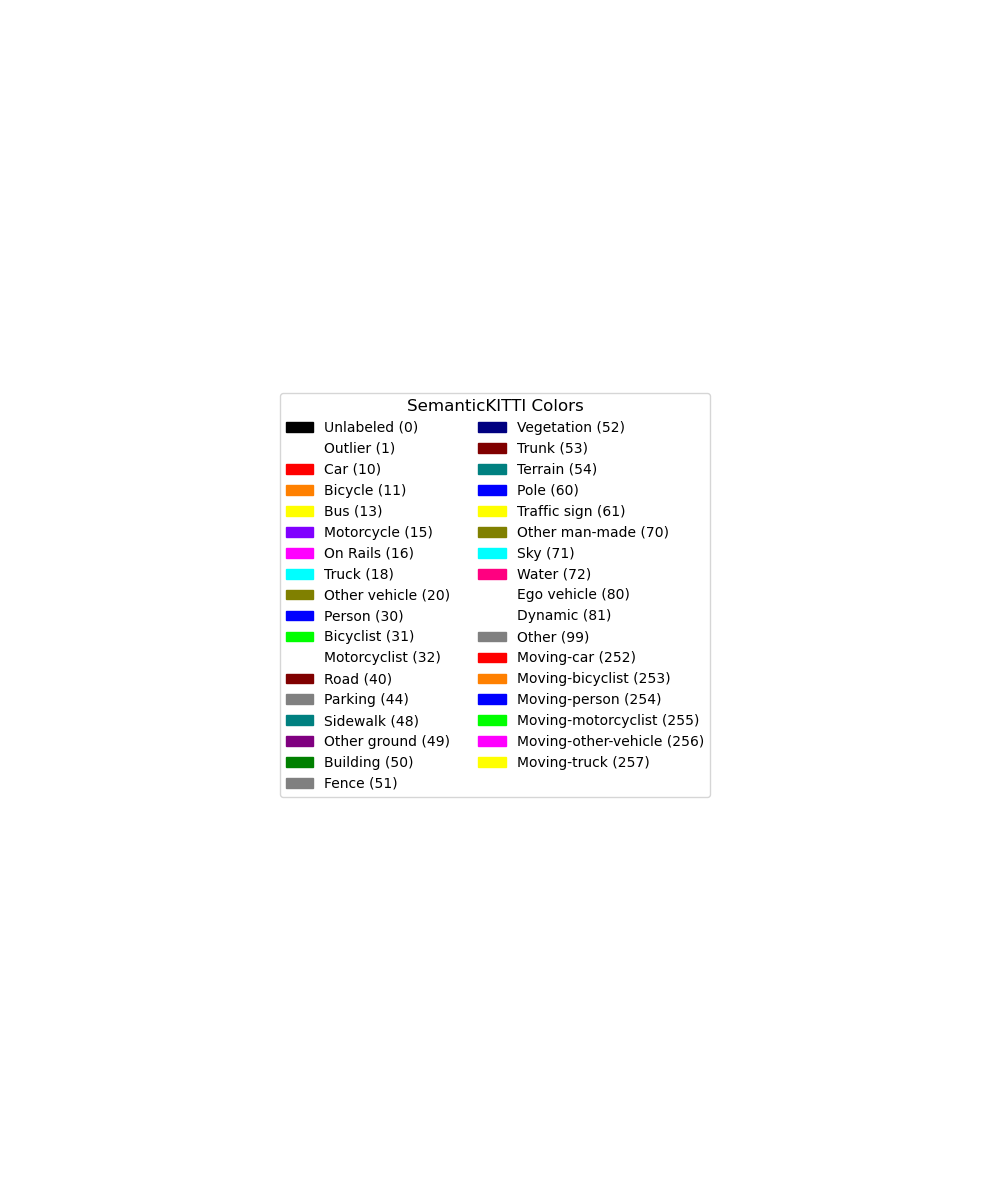

In [1]:
import matplotlib.patches as mpatches
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image

# Define SemanticKITTI color map for visualization
SEMANTIC_KITTI_COLORMAP = {
    0: [0, 0, 0],          # Unlabeled
    1: [255, 255, 255],    # Outlier
    10: [255, 0, 0],       # Car
    11: [255, 128, 0],     # Bicycle
    13: [255, 255, 0],     # Bus
    15: [128, 0, 255],     # Motorcycle
    16: [255, 0, 255],     # On Rails
    18: [0, 255, 255],     # Truck
    20: [128, 128, 0],     # Other vehicle
    30: [0, 0, 255],       # Person
    31: [0, 255, 0],       # Bicyclist
    32: [255, 255, 255],   # Motorcyclist
    40: [128, 0, 0],       # Road
    44: [128, 128, 128],   # Parking
    48: [0, 128, 128],     # Sidewalk
    49: [128, 0, 128],     # Other ground
    50: [0, 128, 0],       # Building
    51: [128, 128, 128],   # Fence
    52: [0, 0, 128],       # Vegetation
    53: [128, 0, 0],       # Trunk
    54: [0, 128, 128],     # Terrain
    60: [0, 0, 255],       # Pole
    61: [255, 255, 0],     # Traffic sign
    70: [128, 128, 0],     # Other man-made
    71: [0, 255, 255],     # Sky
    72: [255, 0, 128],     # Water
    80: [255, 255, 255],   # Ego vehicle
    81: [255, 255, 255],   # Dynamic
    99: [128, 128, 128],   # Other
    252: [255, 0, 0],      # Moving-car
    253: [255, 128, 0],    # Moving-bicyclist
    254: [0, 0, 255],      # Moving-person
    255: [0, 255, 0],      # Moving-motorcyclist
    256: [255, 0, 255],    # Moving-other-vehicle
    257: [255, 255, 0]     # Moving-truck
}

# Normalize colors to [0, 1] for Open3D compatibility
SEMANTIC_KITTI_COLORMAP = {k: np.array(v) / 255.0 for k, v in SEMANTIC_KITTI_COLORMAP.items()}

CLASS_NAMES = {
    0: "Unlabeled",
    1: "Outlier",
    10: "Car",
    11: "Bicycle",
    13: "Bus",
    15: "Motorcycle",
    16: "On Rails",
    18: "Truck",
    20: "Other vehicle",
    30: "Person",
    31: "Bicyclist",
    32: "Motorcyclist",
    40: "Road",
    44: "Parking",
    48: "Sidewalk",
    49: "Other ground",
    50: "Building",
    51: "Fence",
    52: "Vegetation",
    53: "Trunk",
    54: "Terrain",
    60: "Pole",
    61: "Traffic sign",
    70: "Other man-made",
    71: "Sky",
    72: "Water",
    80: "Ego vehicle",
    81: "Dynamic",
    99: "Other",
    252: "Moving-car",
    253: "Moving-bicyclist",
    254: "Moving-person",
    255: "Moving-motorcyclist",
    256: "Moving-other-vehicle",
    257: "Moving-truck"
}

# Create legend patches
legend_patches = [
    mpatches.Patch(color=SEMANTIC_KITTI_COLORMAP[label], label=f"{CLASS_NAMES[label]} ({label})")
    for label in SEMANTIC_KITTI_COLORMAP.keys()
]

# Set up the figure for visualization
plt.figure(figsize=(10, 12))  # Tall figure to fit all labels
plt.legend(handles=legend_patches, loc='center', ncol=2, fontsize=10, title="SemanticKITTI Colors", title_fontsize=12)
plt.gca().set_axis_off()  # Hide axes for a clean look
plt.tight_layout()
plt.show()

Side by Side actual and predicted pcd visualization

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


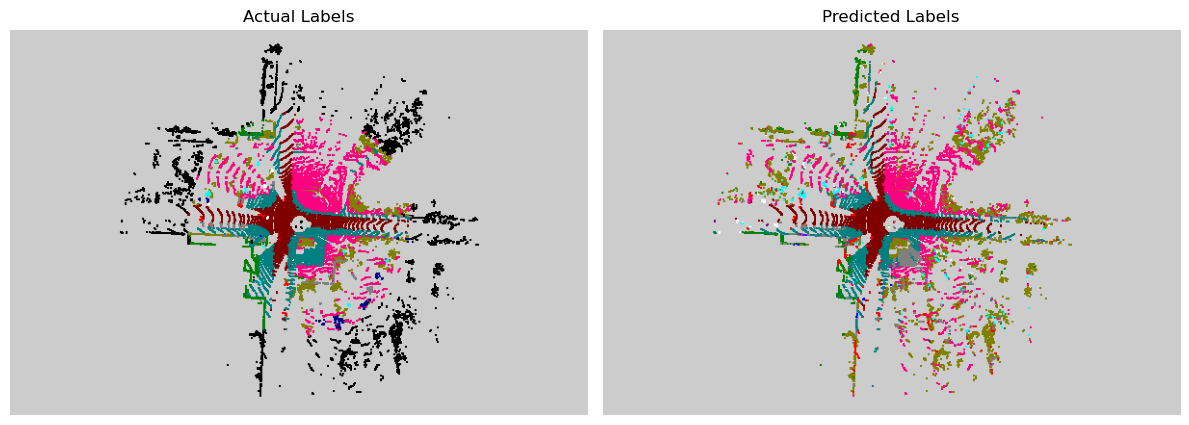

In [8]:
def load_point_cloud(bin_path, label_path):
    """Load a point cloud and apply semantic colors."""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # x, y, z only
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF  # Extract semantic class
    assert points.shape[0] == labels.shape[0], f"Mismatch: {points.shape[0]} points, {labels.shape[0]} labels"
    colors = np.array([SEMANTIC_KITTI_COLORMAP.get(label, [0, 0, 0]) for label in labels])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def render_pcd_to_image(pcd, width=600, height=400):
    """Render a point cloud to a 2D image."""
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=False)  # Off-screen rendering
    vis.add_geometry(pcd)
    render_option = vis.get_render_option()
    render_option.point_size = 2.0
    render_option.background_color = np.array([0.8, 0.8, 0.8])  # Light gray background
    
    # Set a consistent viewpoint
    view_control = vis.get_view_control()
    view_control.set_front([0, 0, -1])  # Looking forward
    view_control.set_up([0, 1, 0])     # Up direction
    view_control.set_zoom(0.5)         # Zoom level
    
    vis.poll_events()
    vis.update_renderer()
    image = vis.capture_screen_float_buffer(do_render=True)
    vis.destroy_window()
    return np.asarray(image)

# Paths for a single frame (e.g., frame 000001)
frame_id = "000031"
pcd_path = f"./data/pcds/{frame_id}.bin"
actual_label_path = f"./data/actual/{frame_id}.label"
pred_label_path = f"./data/pred/{frame_id}.label"

# Load point clouds
pcd_actual = load_point_cloud(pcd_path, actual_label_path)
pcd_pred = load_point_cloud(pcd_path, pred_label_path)

# Render both point clouds to images
img_actual = render_pcd_to_image(pcd_actual)
img_pred = render_pcd_to_image(pcd_pred)

# Display side by side in the notebook
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_actual)
axes[0].set_title("Actual Labels")
axes[0].axis("off")
axes[1].imshow(img_pred)
axes[1].set_title("Predicted Labels")
axes[1].axis("off")
plt.tight_layout()
plt.show()

Car (10): 4.15%
Bicycle (11): 0.00%
Motorcycle (15): 0.04%
Person (30): 0.38%
Bicyclist (31): 0.00%
Road (40): 32.69%
Parking (44): 2.04%
Sidewalk (48): 20.29%
Other ground (49): 0.02%
Building (50): 3.59%
Fence (51): 2.30%
Other man-made (70): 19.19%
Sky (71): 3.20%
Water (72): 10.58%
Ego vehicle (80): 1.03%
Dynamic (81): 0.49%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


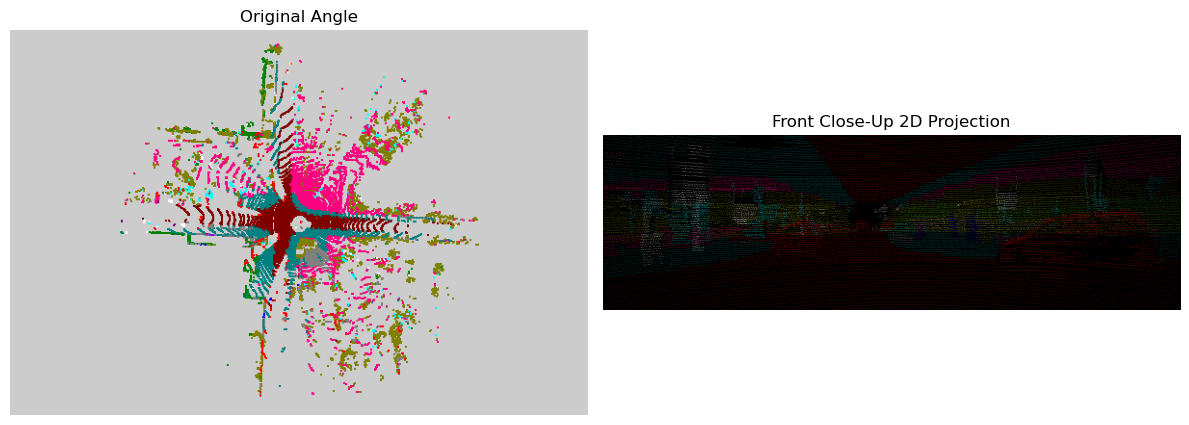

In [13]:
def load_point_cloud(bin_path, label_path):
    """Load point cloud and apply predicted labels as colors."""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # x, y, z only
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF  # Extract semantic class
    colors = np.array([SEMANTIC_KITTI_COLORMAP.get(label, [0, 0, 0]) for label in labels])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd, labels

def render_pcd_to_image(pcd, width=600, height=400):
    """Render point cloud to a 2D image from the original angle."""
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=False)
    vis.add_geometry(pcd)
    render_option = vis.get_render_option()
    render_option.point_size = 2.0
    render_option.background_color = np.array([0.8, 0.8, 0.8])
    
    view_control = vis.get_view_control()
    view_control.set_front([0, 0, -1])  # Default front view
    view_control.set_up([0, 1, 0])
    view_control.set_zoom(0.5)
    
    vis.poll_events()
    vis.update_renderer()
    image = vis.capture_screen_float_buffer(do_render=True)
    vis.destroy_window()
    return np.asarray(image)

def project_to_image(pcd, calib_path, pose_path, frame_id):
    """Project point cloud to 2D image plane using calibration and pose data."""
    # Load calibration data
    with open(calib_path, 'r') as f:
        calib = {}
        for line in f:
            key, value = line.split(':', 1)
            calib[key.strip()] = np.array([float(x) for x in value.split()])
    
    # Load pose for the specific frame
    with open(pose_path, 'r') as f:
        poses = f.readlines()
    pose = np.array([float(x) for x in poses[int(frame_id)].split()]).reshape(3, 4)
    pose = np.vstack([pose, [0, 0, 0, 1]])  # Make it 4x4
    
    # Extract transformation matrices
    Tr = calib['Tr'].reshape(3, 4)
    Tr = np.vstack([Tr, [0, 0, 0, 1]])  # Make it 4x4
    P2 = calib['P2'].reshape(3, 4)
    
    # Transform points to camera coordinate system
    points = np.asarray(pcd.points)
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # Homogeneous coordinates
    points_cam = (Tr @ points_hom.T).T[:, :3]  # Apply Tr to transform to camera frame
    
    # Project to image plane
    points_img = (P2 @ np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]).T).T
    points_img = points_img[:, :2] / points_img[:, 2:]  # Normalize by depth
    
    # Filter points within image bounds (assuming KITTI image size: 1242x375)
    mask = (points_img[:, 0] >= 0) & (points_img[:, 0] < 1242) & (points_img[:, 1] >= 0) & (points_img[:, 1] < 375)
    points_img = points_img[mask]
    colors = np.asarray(pcd.colors)[mask]
    
    # Create an image
    img = np.zeros((375, 1242, 3), dtype=np.uint8)
    for pt, color in zip(points_img, colors):
        x, y = int(pt[0]), int(pt[1])
        img[y, x] = (color * 255).astype(np.uint8)
    
    return img

# Paths for frame 000001 from sequence 08
frame_id = "000031"
pcd_path = f"./data/pcds/{frame_id}.bin"
pred_label_path = f"./data/pred/{frame_id}.label"
calib_path = "./data/calibration/sequences/08/calib.txt"
pose_path = "./data/poses.txt"

# Load point cloud with predicted labels
pcd, labels = load_point_cloud(pcd_path, pred_label_path)

# Calculate and print label percentages
unique_labels, counts = np.unique(labels, return_counts=True)
total_points = labels.shape[0]
for label, count in zip(unique_labels, counts):
    percentage = (count / total_points) * 100
    print(f"{CLASS_NAMES.get(label, 'Unknown')} ({label}): {percentage:.2f}%")

# Render original angle (left)
img_original = render_pcd_to_image(pcd)

# Project to 2D image plane (right)
img_projected = project_to_image(pcd, calib_path, pose_path, frame_id)

# Display side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_original)
axes[0].set_title("Original Angle")
axes[0].axis("off")
axes[1].imshow(img_projected)
axes[1].set_title("Front Close-Up 2D Projection")
axes[1].axis("off")
plt.tight_layout()
plt.show()

Car (10): 4.15%
Bicycle (11): 0.00%
Motorcycle (15): 0.04%
Person (30): 0.38%
Bicyclist (31): 0.00%
Road (40): 32.69%
Parking (44): 2.04%
Sidewalk (48): 20.29%
Other ground (49): 0.02%
Building (50): 3.59%
Fence (51): 2.30%
Other man-made (70): 19.19%
Sky (71): 3.20%
Water (72): 10.58%
Ego vehicle (80): 1.03%
Dynamic (81): 0.49%


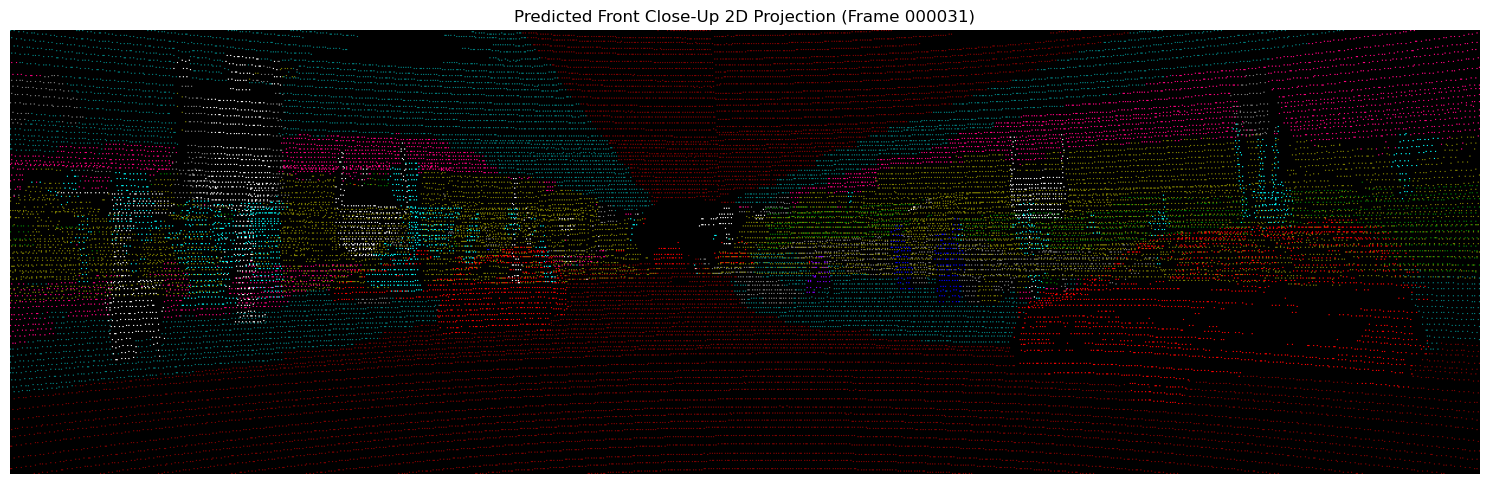

In [12]:
def load_point_cloud(bin_path, label_path):
    """Load point cloud and apply predicted labels as colors."""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # x, y, z only
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF  # Extract semantic class
    colors = np.array([SEMANTIC_KITTI_COLORMAP.get(label, [0, 0, 0]) for label in labels])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd, labels

def project_to_image(pcd, calib_path, pose_path, frame_id):
    """Project point cloud to 2D image plane using calibration and pose data."""
    # Load calibration data
    with open(calib_path, 'r') as f:
        calib = {}
        for line in f:
            key, value = line.split(':', 1)
            calib[key.strip()] = np.array([float(x) for x in value.split()])
    
    # Load pose for the specific frame
    with open(pose_path, 'r') as f:
        poses = f.readlines()
    pose = np.array([float(x) for x in poses[int(frame_id)].split()]).reshape(3, 4)
    pose = np.vstack([pose, [0, 0, 0, 1]])  # Make it 4x4
    
    # Extract transformation matrices
    Tr = calib['Tr'].reshape(3, 4)
    Tr = np.vstack([Tr, [0, 0, 0, 1]])  # Make it 4x4
    P2 = calib['P2'].reshape(3, 4)
    
    # Transform points to camera coordinate system
    points = np.asarray(pcd.points)
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # Homogeneous coordinates
    points_cam = (Tr @ points_hom.T).T[:, :3]  # Apply Tr to transform to camera frame
    
    # Project to image plane
    points_img = (P2 @ np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]).T).T
    points_img = points_img[:, :2] / points_img[:, 2:]  # Normalize by depth
    
    # Filter points within image bounds (KITTI image size: 1242x375)
    mask = (points_img[:, 0] >= 0) & (points_img[:, 0] < 1242) & (points_img[:, 1] >= 0) & (points_img[:, 1] < 375)
    points_img = points_img[mask]
    colors = np.asarray(pcd.colors)[mask]
    
    # Create an image
    img = np.zeros((375, 1242, 3), dtype=np.uint8)
    for pt, color in zip(points_img, colors):
        x, y = int(pt[0]), int(pt[1])
        img[y, x] = (color * 255).astype(np.uint8)
    
    return img

# Paths for frame 000001 from sequence 08
frame_id = "000031"
pcd_path = f"./data/pcds/{frame_id}.bin"
pred_label_path = f"./data/pred/{frame_id}.label"
calib_path = "./data/calibration/sequences/08/calib.txt"
pose_path = "./data/poses.txt"

# Load point cloud with predicted labels
pcd, labels = load_point_cloud(pcd_path, pred_label_path)

# Calculate and print label percentages
unique_labels, counts = np.unique(labels, return_counts=True)
total_points = labels.shape[0]
for label, count in zip(unique_labels, counts):
    percentage = (count / total_points) * 100
    print(f"{CLASS_NAMES.get(label, 'Unknown')} ({label}): {percentage:.2f}%")

# Project to 2D image plane
img_projected = project_to_image(pcd, calib_path, pose_path, frame_id)

# Display single large visualization
plt.figure(figsize=(15, 5))  # Larger figure for a single big image
plt.imshow(img_projected)
plt.title(f"Predicted Front Close-Up 2D Projection (Frame {frame_id})")
plt.axis("off")
plt.tight_layout()
plt.show()

Unlabeled (0): 5.72%
Outlier (1): 0.01%
Car (10): 0.88%
Bicycle (11): 0.05%
Person (30): 0.10%
Road (40): 32.84%
Parking (44): 0.19%
Sidewalk (48): 21.44%
Building (50): 3.70%
Fence (51): 0.45%
Vegetation (52): 0.49%
Other man-made (70): 14.26%
Sky (71): 2.17%
Water (72): 11.47%
Ego vehicle (80): 0.40%
Dynamic (81): 0.59%
Other (99): 2.40%
Moving-car (252): 2.61%
Moving-person (254): 0.25%


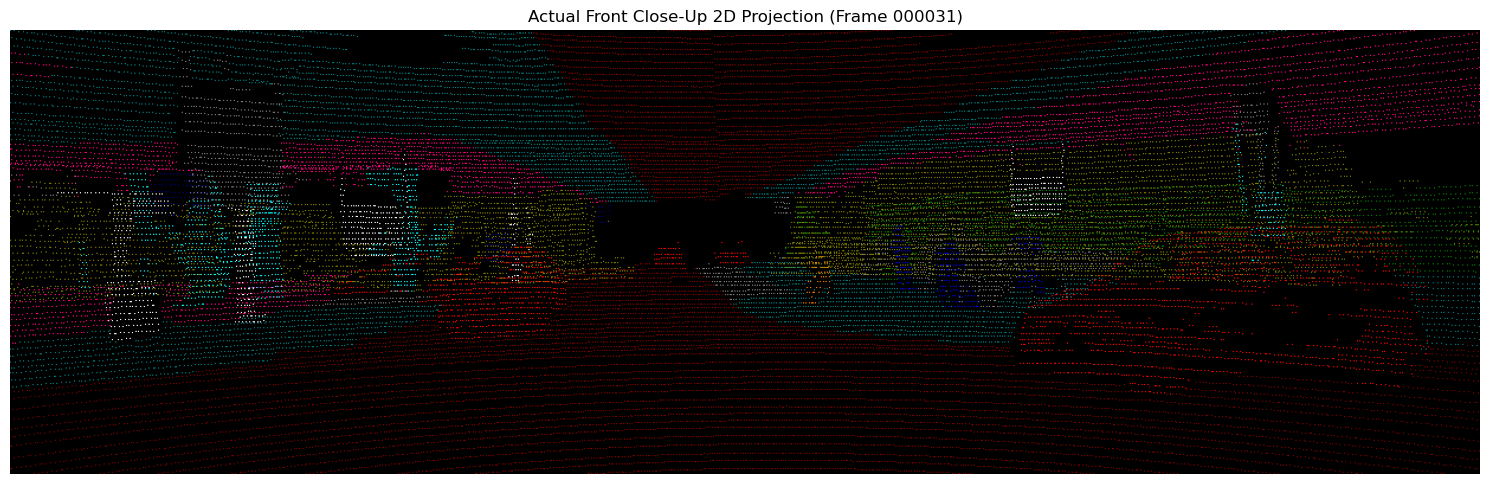

In [5]:
def load_point_cloud(bin_path, label_path):
    """Load point cloud and apply actual labels as colors."""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # x, y, z only
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF  # Extract semantic class
    colors = np.array([SEMANTIC_KITTI_COLORMAP.get(label, [0, 0, 0]) for label in labels])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd, labels

def project_to_image(pcd, calib_path, pose_path, frame_id):
    """Project point cloud to 2D image plane using calibration and pose data."""
    # Load calibration data
    with open(calib_path, 'r') as f:
        calib = {}
        for line in f:
            key, value = line.split(':', 1)
            calib[key.strip()] = np.array([float(x) for x in value.split()])
    
    # Load pose for the specific frame
    with open(pose_path, 'r') as f:
        poses = f.readlines()
    pose = np.array([float(x) for x in poses[int(frame_id)].split()]).reshape(3, 4)
    pose = np.vstack([pose, [0, 0, 0, 1]])  # Make it 4x4
    
    # Extract transformation matrices
    Tr = calib['Tr'].reshape(3, 4)
    Tr = np.vstack([Tr, [0, 0, 0, 1]])  # Make it 4x4
    P2 = calib['P2'].reshape(3, 4)
    
    # Transform points to camera coordinate system
    points = np.asarray(pcd.points)
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # Homogeneous coordinates
    points_cam = (Tr @ points_hom.T).T[:, :3]  # Apply Tr to transform to camera frame
    
    # Project to image plane
    points_img = (P2 @ np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]).T).T
    points_img = points_img[:, :2] / points_img[:, 2:]  # Normalize by depth
    
    # Filter points within image bounds (KITTI image size: 1242x375)
    mask = (points_img[:, 0] >= 0) & (points_img[:, 0] < 1242) & (points_img[:, 1] >= 0) & (points_img[:, 1] < 375)
    points_img = points_img[mask]
    colors = np.asarray(pcd.colors)[mask]
    
    # Create an image
    img = np.zeros((375, 1242, 3), dtype=np.uint8)
    for pt, color in zip(points_img, colors):
        x, y = int(pt[0]), int(pt[1])
        img[y, x] = (color * 255).astype(np.uint8)
    
    return img

# Paths for frame 000001 from sequence 08
frame_id = "000031"  # Changed back to 000001 for consistency with your example
pcd_path = f"./data/pcds/{frame_id}.bin"
actual_label_path = f"./data/actual/{frame_id}.label"  # Updated to use actual labels
calib_path = "./data/calibration/sequences/08/calib.txt"
pose_path = "./data/poses.txt"

# Load point cloud with actual labels
pcd, labels = load_point_cloud(pcd_path, actual_label_path)

# Calculate and print label percentages
unique_labels, counts = np.unique(labels, return_counts=True)
total_points = labels.shape[0]
for label, count in zip(unique_labels, counts):
    percentage = (count / total_points) * 100
    print(f"{CLASS_NAMES.get(label, 'Unknown')} ({label}): {percentage:.2f}%")

# Project to 2D image plane
img_projected = project_to_image(pcd, calib_path, pose_path, frame_id)

# Display single large visualization
plt.figure(figsize=(15, 5))  # Larger figure for a single big image
plt.imshow(img_projected)
plt.title(f"Actual Front Close-Up 2D Projection (Frame {frame_id})")
plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

# Define instance classes (classes with individual instances)
INSTANCE_CLASSES = [10, 11, 13, 15, 16, 18, 20, 30, 31, 32, 252, 253, 254, 255, 256, 257]

# Define class names for readable output
CLASS_NAMES = {
    0: "Unlabeled",
    1: "Outlier",
    10: "Car",
    11: "Bicycle",
    13: "Bus",
    15: "Motorcycle",
    16: "On Rails",
    18: "Truck",
    20: "Other vehicle",
    30: "Person",
    31: "Bicyclist",
    32: "Motorcyclist",
    40: "Road",
    44: "Parking",
    48: "Sidewalk",
    49: "Other ground",
    50: "Building",
    51: "Fence",
    52: "Vegetation",
    53: "Trunk",
    54: "Terrain",
    60: "Pole",
    61: "Traffic sign",
    70: "Other man-made",
    71: "Sky",
    72: "Water",
    80: "Ego vehicle",
    81: "Dynamic",
    99: "Other",
    252: "Moving-car",
    253: "Moving-bicyclist",
    254: "Moving-person",
    255: "Moving-motorcyclist",
    256: "Moving-other-vehicle",
    257: "Moving-truck"
}

def calculate_object_distances(frame_id="000031", pcd_path="./data/pcds/", pred_label_path="./data/pred/", calib_path="./data/calibration/sequences/08/calib.txt"):
    """
    Calculate the minimum distance of each object from the camera view in a SemanticKITTI frame using predicted labels.
    
    Args:
        frame_id (str): Frame identifier (e.g., "000031").
        pcd_path (str): Directory path to point cloud .bin files.
        pred_label_path (str): Directory path to predicted label .label files.
        calib_path (str): Path to calibration file (calib.txt).
    
    Returns:
        None: Prints distances to console based on predicted labels, or debug info if no instances found.
    """
    # Construct full file paths
    pcd_file = f"{pcd_path}{frame_id}.bin"
    label_file = f"{pred_label_path}{frame_id}.label"

    # Load point cloud points (x, y, z)
    try:
        points = np.fromfile(pcd_file, dtype=np.float32).reshape(-1, 4)[:, :3]
        print(f"Loaded {points.shape[0]} points from {pcd_file}")
    except Exception as e:
        print(f"Error loading point cloud file {pcd_file}: {e}")
        return

    # Load full labels (32-bit integers containing semantic and instance info) from predicted file
    try:
        labels = np.fromfile(label_file, dtype=np.uint32)
        print(f"Loaded {labels.shape[0]} labels from {label_file}")
    except Exception as e:
        print(f"Error loading label file {label_file}: {e}")
        return

    semantic_labels = labels & 0xFFFF  # Lower 16 bits: semantic label
    instance_ids = labels >> 16        # Upper 16 bits: instance ID
    print(f"Unique semantic labels: {np.unique(semantic_labels)}")
    print(f"Unique instance IDs: {np.unique(instance_ids)}")

    # Load calibration data
    try:
        with open(calib_path, 'r') as f:
            calib = {}
            for line in f:
                key, value = line.split(':', 1)
                calib[key.strip()] = np.array([float(x) for x in value.split()])
        print(f"Loaded calibration data from {calib_path}")
    except Exception as e:
        print(f"Error loading calibration file {calib_path}: {e}")
        return

    # Extract transformation matrix (Tr: LiDAR to camera)
    Tr = calib['Tr'].reshape(3, 4)
    Tr = np.vstack([Tr, [0, 0, 0, 1]])  # Make it 4x4

    # Extract projection matrix (P2: camera projection matrix)
    P2 = calib['P2'].reshape(3, 4)

    # Transform points to camera coordinate system
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # Homogeneous coordinates
    points_cam = (Tr @ points_hom.T).T[:, :3]  # Apply Tr to get points in camera frame

    # Project points to image plane to determine visible points
    points_img = (P2 @ np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]).T).T
    points_img = points_img[:, :2] / points_img[:, 2:]  # Normalize by depth
    mask = (points_img[:, 0] >= 0) & (points_img[:, 0] < 1242) & (points_img[:, 1] >= 0) & (points_img[:, 1] < 375)
    print(f"Number of visible points: {np.sum(mask)}")

    # Filter visible points and labels
    visible_points_cam = points_cam[mask]
    visible_semantic_labels = semantic_labels[mask]
    visible_instance_ids = instance_ids[mask]

    # Find unique instances among visible points
    unique_instances = set()
    for sem, inst in zip(visible_semantic_labels, visible_instance_ids):
        if sem in INSTANCE_CLASSES and inst > 0:
            unique_instances.add((sem, inst))

    # Check if any instances were found
    if not unique_instances:
        print("No instances found with non-zero instance IDs from INSTANCE_CLASSES.")
        print(f"Visible semantic labels: {np.unique(visible_semantic_labels)}")
        print(f"Visible instance IDs: {np.unique(visible_instance_ids)}")
        return

    # Calculate minimum distance for each instance
    instance_distances = {}
    for sem, inst in unique_instances:
        instance_mask = (visible_semantic_labels == sem) & (visible_instance_ids == inst)
        instance_points = visible_points_cam[instance_mask]
        if instance_points.size > 0:
            distances = np.linalg.norm(instance_points, axis=1)  # Euclidean distance from camera origin
            min_distance = np.min(distances)
            instance_distances[(sem, inst)] = min_distance

    # Print distances
    if instance_distances:
        for (sem, inst), dist in instance_distances.items():
            class_name = CLASS_NAMES.get(sem, "Unknown")
            print(f"{class_name} (Instance {inst}): {dist:.2f} meters")
    else:
        print("No valid instance points found after filtering.")

if __name__ == "__main__":
    # Default paths for frame 000031 from sequence 08 using predicted labels
    calculate_object_distances(
        frame_id="000031",
        pcd_path="./data/pcds/",
        pred_label_path="./data/actual/",
        calib_path="./data/calibration/sequences/08/calib.txt"
    )

Loaded 123409 points from ./data/pcds/000031.bin
Loaded 123409 labels from ./data/actual/000031.label
Unique semantic labels: [  0   1  10  11  30  40  44  48  50  51  52  70  71  72  80  81  99 252
 254]
Unique instance IDs: [  0   1   2   3   4   9  10  15  24  25 194 195 196 197 198 199]
Loaded calibration data from ./data/calibration/sequences/08/calib.txt
Number of visible points: 40614
Moving-car (Instance 4): 14.42 meters
Person (Instance 10): 19.44 meters
Moving-car (Instance 1): 7.95 meters
Bicycle (Instance 25): 31.75 meters
Person (Instance 9): 18.42 meters
Car (Instance 199): 38.31 meters
Moving-person (Instance 2): 17.45 meters
Bicycle (Instance 24): 20.10 meters
Person (Instance 15): 21.79 meters
Car (Instance 198): 26.57 meters
Moving-car (Instance 2): 42.80 meters


In [7]:
import numpy as np

# Define instance classes (classes with individual instances)
INSTANCE_CLASSES = [10, 11, 13, 15, 16, 18, 20, 30, 31, 32, 252, 253, 254, 255, 256, 257]

# Define class names for readable output
CLASS_NAMES = {
    0: "Unlabeled",
    1: "Outlier",
    10: "Car",
    11: "Bicycle",
    13: "Bus",
    15: "Motorcycle",
    16: "On Rails",
    18: "Truck",
    20: "Other vehicle",
    30: "Person",
    31: "Bicyclist",
    32: "Motorcyclist",
    40: "Road",
    44: "Parking",
    48: "Sidewalk",
    49: "Other ground",
    50: "Building",
    51: "Fence",
    52: "Vegetation",
    53: "Trunk",
    54: "Terrain",
    60: "Pole",
    61: "Traffic sign",
    70: "Other man-made",
    71: "Sky",
    72: "Water",
    80: "Ego vehicle",
    81: "Dynamic",
    99: "Other",
    252: "Moving-car",
    253: "Moving-bicyclist",
    254: "Moving-person",
    255: "Moving-motorcyclist",
    256: "Moving-other-vehicle",
    257: "Moving-truck"
}

def calculate_object_distances(frame_id="000031", pcd_path="./data/pcds/", pred_label_path="./data/pred/", calib_path="./data/calibration/sequences/08/calib.txt"):
    """
    Calculate the minimum distance of each object class from the camera view in a SemanticKITTI frame using predicted labels.
    
    Args:
        frame_id (str): Frame identifier (e.g., "000031").
        pcd_path (str): Directory path to point cloud .bin files.
        pred_label_path (str): Directory path to predicted label .label files.
        calib_path (str): Path to calibration file (calib.txt).
    
    Returns:
        None: Prints distances to console based on predicted labels.
    """
    # Construct full file paths
    pcd_file = f"{pcd_path}{frame_id}.bin"
    label_file = f"{pred_label_path}{frame_id}.label"

    # Load point cloud points (x, y, z)
    try:
        points = np.fromfile(pcd_file, dtype=np.float32).reshape(-1, 4)[:, :3]
        print(f"Loaded {points.shape[0]} points from {pcd_file}")
    except Exception as e:
        print(f"Error loading point cloud file {pcd_file}: {e}")
        return

    # Load full labels (32-bit integers containing semantic and instance info) from predicted file
    try:
        labels = np.fromfile(label_file, dtype=np.uint32)
        print(f"Loaded {labels.shape[0]} labels from {label_file}")
    except Exception as e:
        print(f"Error loading label file {label_file}: {e}")
        return

    semantic_labels = labels & 0xFFFF  # Lower 16 bits: semantic label
    instance_ids = labels >> 16        # Upper 16 bits: instance ID (not used here)
    print(f"Unique semantic labels: {np.unique(semantic_labels)}")

    # Load calibration data
    try:
        with open(calib_path, 'r') as f:
            calib = {}
            for line in f:
                key, value = line.split(':', 1)
                calib[key.strip()] = np.array([float(x) for x in value.split()])
        print(f"Loaded calibration data from {calib_path}")
    except Exception as e:
        print(f"Error loading calibration file {calib_path}: {e}")
        return

    # Extract transformation matrix (Tr: LiDAR to camera)
    Tr = calib['Tr'].reshape(3, 4)
    Tr = np.vstack([Tr, [0, 0, 0, 1]])  # Make it 4x4

    # Extract projection matrix (P2: camera projection matrix)
    P2 = calib['P2'].reshape(3, 4)

    # Transform points to camera coordinate system
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # Homogeneous coordinates
    points_cam = (Tr @ points_hom.T).T[:, :3]  # Apply Tr to get points in camera frame

    # Project points to image plane to determine visible points
    points_img = (P2 @ np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]).T).T
    points_img = points_img[:, :2] / points_img[:, 2:]  # Normalize by depth
    mask = (points_img[:, 0] >= 0) & (points_img[:, 0] < 1242) & (points_img[:, 1] >= 0) & (points_img[:, 1] < 375)
    print(f"Number of visible points: {np.sum(mask)}")

    # Filter visible points and labels
    visible_points_cam = points_cam[mask]
    visible_semantic_labels = semantic_labels[mask]

    # Find unique object classes among visible points
    unique_classes = set()
    for sem in visible_semantic_labels:
        if sem in INSTANCE_CLASSES:
            unique_classes.add(sem)

    # Check if any object classes were found
    if not unique_classes:
        print("No object classes from INSTANCE_CLASSES found in visible points.")
        print(f"Visible semantic labels: {np.unique(visible_semantic_labels)}")
        return

    # Calculate minimum distance for each object class
    class_distances = {}
    for sem in unique_classes:
        class_mask = (visible_semantic_labels == sem)
        class_points = visible_points_cam[class_mask]
        if class_points.size > 0:
            distances = np.linalg.norm(class_points, axis=1)  # Euclidean distance from camera origin
            min_distance = np.min(distances)
            class_distances[sem] = min_distance

    # Print distances
    if class_distances:
        for sem, dist in class_distances.items():
            class_name = CLASS_NAMES.get(sem, "Unknown")
            print(f"{class_name}: {dist:.2f} meters")
    else:
        print("No valid points found for object classes after filtering.")

if __name__ == "__main__":
    # Default paths for frame 000031 from sequence 08 using predicted labels
    calculate_object_distances(
        frame_id="000031",
        pcd_path="./data/pcds/",
        pred_label_path="./data/pred/",
        calib_path="./data/calibration/sequences/08/calib.txt"
    )

Loaded 123409 points from ./data/pcds/000031.bin
Loaded 123409 labels from ./data/pred/000031.label
Unique semantic labels: [10 11 15 30 31 40 44 48 49 50 51 70 71 72 80 81]
Loaded calibration data from ./data/calibration/sequences/08/calib.txt
Number of visible points: 40614
Car: 7.95 meters
Person: 17.45 meters
Motorcycle: 20.11 meters


In [12]:
import struct

def bin_to_ascii_pcd(bin_file, output_file, fields=['x', 'y', 'z'], size=[4, 4, 4], type_=['F', 'F', 'F'], count=[1, 1, 1]):
    """
    Converts a binary PCD file (in .bin format) to a human-readable ASCII PCD file.
    Assumes each point is structured as x, y, z in float32 format.
    """

    # Calculate number of bytes per point
    point_size = sum([s * c for s, c in zip(size, count)])

    # Read binary data
    with open(bin_file, 'rb') as f:
        data = f.read()
    
    num_points = len(data) // point_size
    print(f"Number of points: {num_points}")

    # Unpack the binary data
    points = []
    for i in range(num_points):
        offset = i * point_size
        point = struct.unpack('fff', data[offset:offset+point_size])
        points.append(point)

    # Write to ASCII PCD file
    with open(output_file, 'w') as f:
        f.write("# .PCD v0.7 - Point Cloud Data file format\n")
        f.write("VERSION 0.7\n")
        f.write(f"FIELDS {' '.join(fields)}\n")
        f.write(f"SIZE {' '.join(str(s) for s in size)}\n")
        f.write(f"TYPE {' '.join(type_)}\n")
        f.write(f"COUNT {' '.join(str(c) for c in count)}\n")
        f.write(f"WIDTH {num_points}\n")
        f.write("HEIGHT 1\n")
        f.write("VIEWPOINT 0 0 0 1 0 0 0\n")
        f.write(f"POINTS {num_points}\n")
        f.write("DATA ascii\n")
        for p in points:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")

    print(f"ASCII PCD written to {output_file}")

num = "000009"
# Example usage
bin_to_ascii_pcd(f'08/pcds/{num}.bin', f'{num}.pcd')


Number of points: 164593
ASCII PCD written to 000009.pcd
